In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm
import pandas as pd

In [2]:
class RestartBandits:
    A=0.9
    def __init__(self):
        self.P_0_matrix=np.array([[0.1,0.9,0,0,0],
                    [0.1,0,0.9,0,0],
                    [0.1,0,0,0.9,0],
                    [0.1,0,0,0,0.9],
                    [0.1,0,0,0,0.9]]) 
        self.P_1_matrix=np.array([[1,0,0,0,0],
                    [1,0,0,0,0],
                    [1,0,0,0,0],
                    [1,0,0,0,0],
                    [1,0,0,0,0]])
        self.action_space=[0,1]
        self.state_space=[0,1,2,3,4]
        self.reward_matrix=[[self.A**1,0],[self.A**2,0],[self.A**3,0],[self.A**4,0],[self.A**5,0]]        
    def step(self,state,action):
        new_state=state
        if(action==1):
            new_state=np.random.choice(self.state_space,replace=True,p=self.P_1_matrix[state])
            reward=self.reward_matrix[state][1]
        else:
            new_state=np.random.choice(self.state_space,replace=True,p=self.P_0_matrix[state])
            reward=self.reward_matrix[state][0]
        return [new_state,reward]
    




In [3]:
class CircularBandits:
    def __init__(self):
        self.P_0_matrix=np.array([[0.5,0,0,0.5],
                   [0.5,0.5,0,0],
                   [0,0.5,0.5,0],
                   [0,0,0.5,0.5]])
        self.P_1_matrix=self.P_0_matrix.transpose()
        self.action_space=[0,1]
        self.state_space=[0,1,2,3]
        self.reward_matrix=[[-1,-1],[0,0],[0,0],[1,1]]
    def step(self,state,action):
        new_state=state
        if(action==1):
            new_state=np.random.choice(self.state_space,replace=True,p=self.P_1_matrix[state])
            reward=self.reward_matrix[state][1]
        else:
            new_state=np.random.choice(self.state_space,replace=True,p=self.P_0_matrix[state])
            reward=self.reward_matrix[state][0]
        return [new_state,reward]


In [4]:
restart_bandits=RestartBandits()
circular_bandits=CircularBandits()

In [5]:
def Q_value_update(Q_values,state,next_state,action,reward,arm_index,subsidy,alpha):
        if action==1:
            Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)
        else:
            Q_values[arm_index][state][action]=(1-alpha)*(Q_values[arm_index][state][action])+alpha*(reward+subsidy+max(Q_values[arm_index][next_state])-(np.array(Q_values[arm_index]).sum())/8)
def act(Q_values,epsilon,state,arm_index):
    decision=np.random.binomial(n=1,p=epsilon,size=1)
    if decision==1:
        action=random.choice([0,1])
    else:
        action=np.argmax(Q_values[arm_index][state])
    return action

In [6]:
N=100
#50 circular and 50 restart bandits
M=20
epsilon=1
subsidy=0
arm_indexes=[i for i in range(N)]
gamma=0.99

In [7]:
alternative_indexes=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
Q_values=[]
a=RestartBandits.A

for i in range(N):
    if i<50:
        Q_values.append([[a**1,0],[a**2,0],[a**3,0],[a**4,0],[a**5,0]])
    else:
        Q_values.append([[-1,-1],[0,0],[0,0],[1,1]])

In [8]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=1

In [9]:
for i in range(1,700001):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  alpha=1/(1+(i/500))
  beta=1/(1+(i*np.log(i)/500))
  for index in arm_indexes:
      if index<50:
      # action=np.argmax(Q_values[index][current_state[index]])
        action=act(Q_values,epsilon,current_state[index],index)
        action_sum+=action
        x=restart_bandits.step(current_state[index],action)
        new_state=x[0]
        reward=x[1]
        Q_value_update(Q_values,current_state[index],new_state,action,reward,index,subsidy,alpha)
        current_state[index]=new_state
        reward_sum+=reward
      else: 
        action=act(Q_values,epsilon,current_state[index],index)
        action_sum+=action
        x=circular_bandits.step(current_state[index],action)
        new_state=x[0]
        reward=x[1]
        Q_value_update(Q_values,current_state[index],new_state,action,reward,index,subsidy,alpha)
        current_state[index]=new_state
        reward_sum+=reward
      #print(x)
  # print(i)
  #print(reward_sum)

  subsidy+=beta*(action_sum-M)
  subsidies.append(subsidy)
  epsilon=epsilon*gamma
  if epsilon<=0.01:
    epsilon=0.01
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  betas.append(beta)
  alphas.append(alpha)








Text(0.5, 1.0, 'Subsidy vs Steps for Combined Example')

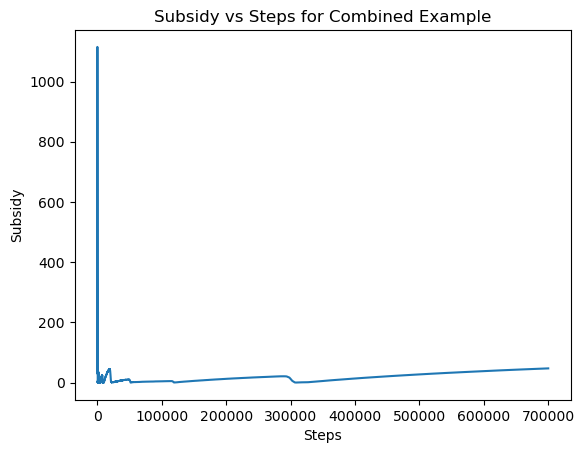

In [10]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Combined Example')

In [11]:
df=pd.DataFrame(rewards)


Text(0.5, 1.0, ' Moving Average of number of arms activated for Combined Example ')

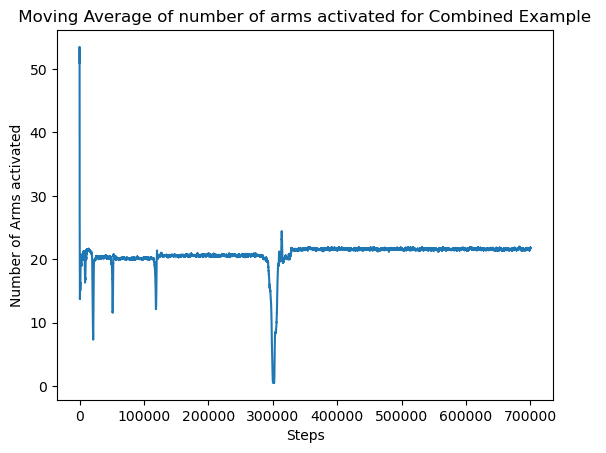

In [12]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(1000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Combined Example ')

In [13]:
df['action_sums'][len(df['action_sums'])-9]

20

Text(0.5, 1.0, ' Moving Average of reward for Combined Example ')

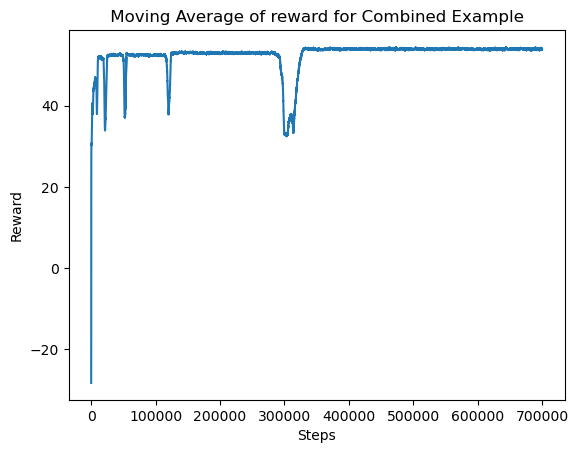

In [14]:
plt.plot(df[0].rolling(1000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Combined Example ')

In [15]:
x=df['action_sums'].rolling(1000,min_periods=1).mean()
x[340000]

21.702

In [16]:
actual_whittle_indexes_restart=[-0.9,-0.73,-0.5,-0.26,-0.01]
actual_whittle_indexes_circular=[-0.5,0.5,1,-1]



Online Comaprison

In [17]:
#using learnt indices
current_state=[0 for _ in range(N)]
reward_sums_alt_index=[]
reward_sums_whittle_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,700001):
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q_values[index][current_state[index]][1]-Q_values[index][current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      if index<50:
        x=restart_bandits.step(current_state[index],1)
        new_state=x[0]
        reward=x[1]
        current_state[index]=new_state
        reward_sum_alt_index+=reward
      else:
        x=circular_bandits.step(current_state[index],1)
        new_state=x[0]
        reward=x[1]
        current_state[index]=new_state
        reward_sum_alt_index+=reward
    else:
      if index<50:
        x=restart_bandits.step(current_state[index],0)
        new_state=x[0]
        reward=x[1]
        current_state[index]=new_state
        reward_sum_alt_index+=reward
      else:
        x=circular_bandits.step(current_state[index],0)
        new_state=x[0]
        reward=x[1]
        current_state[index]=new_state
        reward_sum_alt_index+=reward

  reward_sums_alt_index.append(reward_sum_alt_index)


In [18]:
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
for i in range(1,700001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    if index<50:
        whittle_index_arms[index]=actual_whittle_indexes_restart[current_state[index]]
    else:
        whittle_index_arms[index]=actual_whittle_indexes_circular[current_state[index]]
      
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
        if index<50:
            x=restart_bandits.step(current_state[index],1)
            new_state=x[0]
            reward=x[1]
            current_state[index]=new_state
            reward_sum_whittle_index+=reward
        else:
            x=circular_bandits.step(current_state[index],1)
            new_state=x[0]
            reward=x[1]
            current_state[index]=new_state
            reward_sum_whittle_index+=reward
           
        
    else:
        if index<50:
            x=restart_bandits.step(current_state[index],0)
            new_state=x[0]
            reward=x[1]
            current_state[index]=new_state
            reward_sum_whittle_index+=reward
        else:
            x=circular_bandits.step(current_state[index],0)
            new_state=x[0]
            reward=x[1]
            current_state[index]=new_state
            reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

Text(0.5, 1.0, ' Moving Average of reward for Combined Example ')

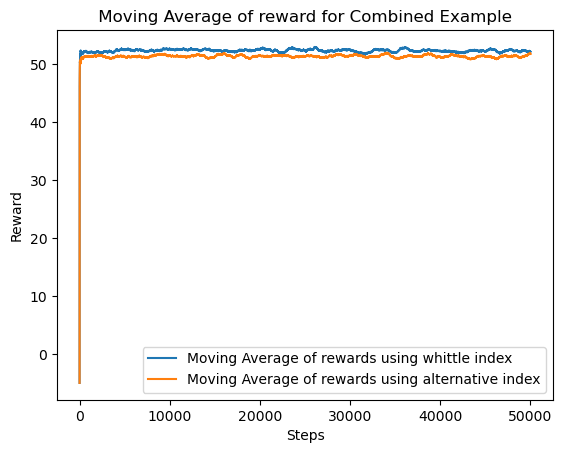

In [19]:
df['reward_whittle']=reward_sums_whittle_index
df['reward_alternate']=reward_sums_alt_index

plt.plot(df['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Combined Example ')